In [7]:
import numpy
import scipy
import matplotlib.pyplot as plt


dt = 0.001 

# create dynamical system
# dx = Ax + Bu
# servo model, 3rd order
# state x = (position, angular velocity, current)

mat_a = numpy.zeros((3, 3))
mat_b = numpy.zeros((3, 1))

J = 0.02    #rotor moment of inertia (kg.m^2)
b = 0.2     #drag coefficient (N/m/s)
K = 0.3     #motor constant (N.m.A^-1)
R = 2.0     #wiring resitance, (ohm)
L = 0.4     #wiring inductance, (H)

mat_a[0][1] = 1.0

mat_a[1][1] = -b/J
mat_a[1][2] = K/J

mat_a[2][1] = -K/J
mat_a[2][2] = -R/L

mat_b[2][0] = 1.0/L

# print system dynamics

print("continuous model")
print(mat_a)
print(mat_b)
print()

# discretise model using bilinear transform
# x(n+1) = A x(n) + B u(n)
i = numpy.eye(mat_a.shape[0])
 
tmp_a = numpy.linalg.inv(i - (0.5*dt)*mat_a)
tmp_b = i + (0.5*dt)*mat_a

mat_a_disc    = tmp_a@tmp_b
mat_b_disc    = (tmp_a*dt)@mat_b

print("discrete model")
print(mat_a_disc)
print(mat_b_disc) 
print()



continuous model
[[  0.   1.   0.]
 [  0. -10.  15.]
 [  0. -15.  -5.]]
[[0. ]
 [0. ]
 [2.5]]

discrete model
[[ 1.00000000e+00  9.94969326e-04  7.44366079e-06]
 [ 0.00000000e+00  9.89938652e-01  1.48873216e-02]
 [ 0.00000000e+00 -1.48873216e-02  9.94901092e-01]]
[[9.30457599e-09]
 [1.86091520e-05]
 [2.49362637e-03]]



In [8]:
'''
solve the discrete time lqr controller for
x(n+1) = A x(n) + B u(n)
cost = sum x[n].T*Q*x[n] + u[n].T*R*u[n]
'''
def solve_discrete_lqr(a, b, q, r):

    n = a.shape[0]  #system order
    m = b.shape[1]  #inputs count
    k = a.shape[0]  #outputs count

    #matrix augmentation with integral action
    a_aug = numpy.zeros((n+k, n+k))
    b_aug = numpy.zeros((n+k, m))
    q_aug = numpy.zeros((n+k, n+k))

    
    a_aug[0:n, 0:n] = a 

    #add integrator into augmented a matrix
    for i in range(n):
        a_aug[i + n, i]     = 1.0
        a_aug[i + n, i + n] = 1.0

    b_aug[0:n,0:m]  = b

    #project Q matric to output, and fill augmented q matrix
    q_aug[n:, n:] = q

    # discrete-time algebraic Riccati equation solution
    p = scipy.linalg.solve_discrete_are(a_aug, b_aug, q_aug, r)

    # compute the LQR gain
    ki_tmp =  numpy.linalg.inv(r)@(b_aug.T@p)

    #truncated small elements
    ki_tmp[numpy.abs(ki_tmp) < 10**-10] = 0

    #split ki for k and integral action part ki
    k   = ki_tmp[:, 0:a.shape[0]]
    ki  = ki_tmp[:, a.shape[0]:]

    return k, ki


#create loss weighting matrices (diagonal)
q = numpy.array([ [1.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0] ] )
r = numpy.array( [ [200.0] ]) 

k, ki = solve_discrete_lqr(mat_a_disc, mat_b_disc, q, r)

print("k  = ", k)
print("ki = ", ki)
    

k  =  [[36.47436718  0.85289638  1.77290253]]
ki =  [[0.07086738 0.         0.        ]]


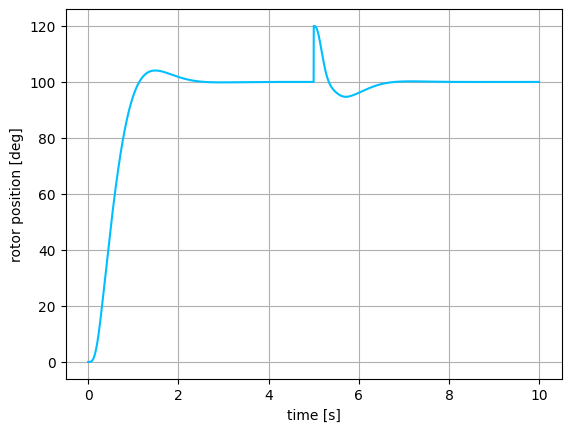

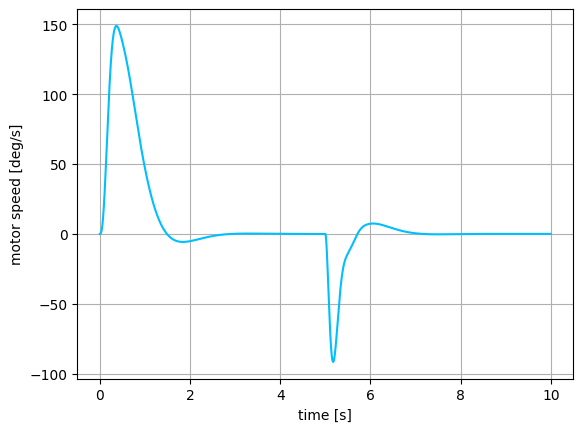

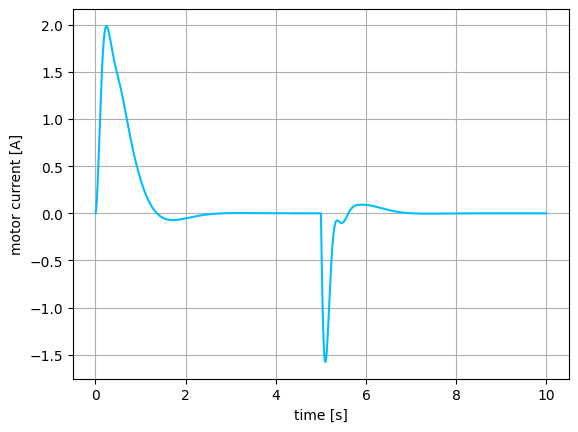

In [9]:
n_max = 10000

#required state, 100degrees
xr = numpy.zeros((mat_a.shape[0], 1))
xr[0][0] = 100.0*numpy.pi/180.0

#initial motor state
x         = numpy.zeros((mat_a.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((mat_b.shape[1], 1))

#result log
t_result = []
x_result = []

for n in range(n_max):

    #integral action
    error = xr - x 
    integral_action+= ki@error

    #LQR controll law
    u = -k@x + integral_action

    #compute plant output
    #primitive euler method for integration
    dx = mat_a@x + mat_b@u
    x+= dx*dt

    #add distrubance in middle, 20degrees
    if n == n_max//2:
        x[0]+= 20.0*numpy.pi/180.0

    x_result.append(x[:, 0].copy())
    t_result.append(n*dt)
    

x_result = numpy.array(x_result)


# plot results
# angles convert into degrees


plt.clf()
plt.plot(t_result, x_result[:, 0]*180.0/numpy.pi, color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("rotor position [deg]")
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, x_result[:, 1]*180.0/numpy.pi, color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("motor speed [deg/s]")
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, x_result[:, 2], color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("motor current [A]")
plt.grid()
plt.show()